<a href="https://colab.research.google.com/github/pranshudiwan/NLP_CS_6200/blob/main/NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sindhu Baseline LSTM

In [6]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Import train data
url_train = 'https://raw.githubusercontent.com/pranshudiwan/NLP_CS_6200/main/train.csv'
train = pd.read_csv(url_train)

# Import est data
url_test = 'https://raw.githubusercontent.com/pranshudiwan/NLP_CS_6200/main/test.csv'
test = pd.read_csv(url_test)

## Visualization
- Class Distribution (number of tweets in each class)
- Number of characters in tweets
- Number of words in tweets
- Average length of word in a tweet

0    4342
1    3271
Name: target, dtype: int64 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


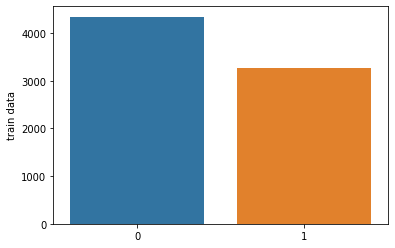

In [17]:
# Class distribution
class_counts=train.target.value_counts()
sns.barplot(class_counts.index,class_counts)
plt.gca().set_ylabel('train data')

print(class_counts , "\n")

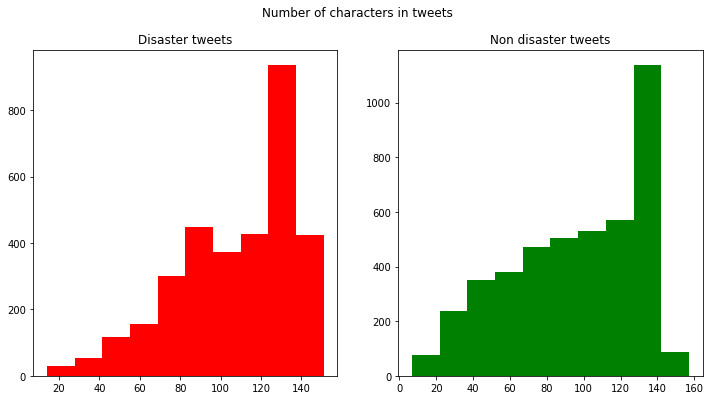

In [24]:
# Number of characters in tweets

# For Disaster tweets
disaster_tweet_len=train[train['target']==1]['text'].str.len()
#print(disaster_tweet_len)
non_disaster_tweet_len=train[train['target']==0]['text'].str.len()
#print(non_disaster_tweet_len)


# plotting
plot,(subplot1,subplot2)=plt.subplots(1,2,figsize=(12,6))
subplot1.hist(disaster_tweet_len,color='red')
subplot1.set_title('Disaster tweets')
subplot2.hist(non_disaster_tweet_len,color='green')
subplot2.set_title('Non disaster tweets')
plot.suptitle('Number of characters in tweets')
plt.show()

In [ ]:
# Number of words in tweets



In [ ]:
# Average length of word in a tweet